# Homework 6

Camille Girard

MIT License: https://opensource.org/licenses/MIT

In [211]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

from scipy.stats import norm, poisson

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint
import scipy as sp

import thinkbayes2
import thinkplot

import pymc3 as pm
import theano.tensor as T


from matplotlib import pyplot as plt

ERROR:root:The 'ast_node_interactivity' trait of a ZMQInteractiveShell instance must be any of ['all', 'last', 'last_expr', 'none'], but a value of 'last_expr_or_assign' <class 'str'> was specified.


## The Nile Problem

The nile rivers trends seem to have quickly changed at some point - this is an analysis of where and how much that change was.

First use a changepoint algorithim in pymc in order to identify when the mean changed and to have the normal distributions for the means in each half. 

In [72]:
import statsmodels.api as sm

data = sm.datasets.nile.load()

In [3]:
nile = sm.datasets.get_rdataset("Nile")
nile.data.head()

,time,value
0,1871,1120
1,1872,1160
2,1873,963
3,1874,1210
4,1875,1160


In [4]:
data = nile.data['value']
print(data.head())

0    1120
1    1160
2     963
3    1210
4    1160
Name: value, dtype: int64


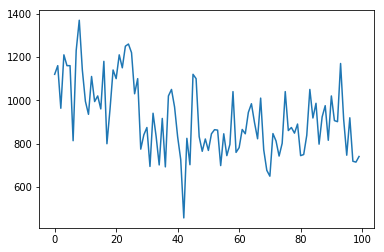

In [170]:
nile.data['value'].plot()

In [34]:
niter = 100000
t = range(len(data))
with pm.Model() as change_point:
    cp = pm.DiscreteUniform('change_point', lower=0, upper=len(data))
    mu0 = pm.Uniform('mu0', 500,1200)
    mu1 = pm.Uniform('mu1', 500,1200)
    mu = T.switch(t < cp, mu0, mu1)
    Y_obs = pm.Normal('Y_obs', mu=mu, sd = data.mean(), observed=data)
    trace = pm.sample(niter)

Sampling 4 chains: 100%|██████████| 402000/402000 [01:36<00:00, 4159.19draws/s]


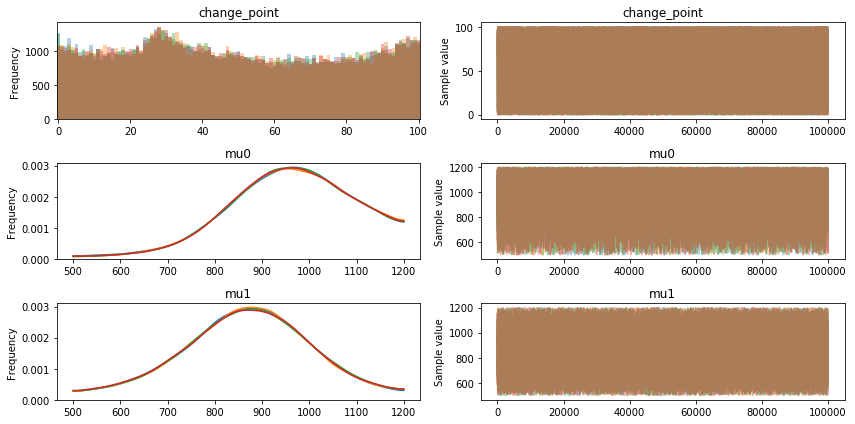

In [35]:
pm.traceplot(trace, varnames=['change_point', 'mu0', 'mu1'])
pass

With all the noise the model is not very convinced that the changepoint is at 30, however there is a  small spike. The means are also relatively different, with the earlier mean being higher before the changepoint, fitting with the plot given by the data.

### Change in the Regression

It also seems that there is a change in the regression before and after the changepoint. For this I will calculate a regression before at after 30, which is around where the change happens, and will see what this shows.

In [160]:
first = nile.data['value'][0:30]
t1 = nile.data['time'][0:30]
second = nile.data['value'][30:]
t2 = nile.data['time'][30:]

In [161]:
with pm.Model() as model:
    slope = pm.Uniform('slope', -10, 10)
    inter = pm.Uniform('inter', 100, 10000)
    sigma = pm.Uniform('sigma', 0, 1000)

    y_est = slope* (t1-1870) + inter
    y = pm.Normal('y', mu=y_est, sd=sigma, observed= first)
    trace = pm.sample(4000, tune=20000)

Sampling 4 chains: 100%|██████████| 96000/96000 [00:32<00:00, 2993.81draws/s]


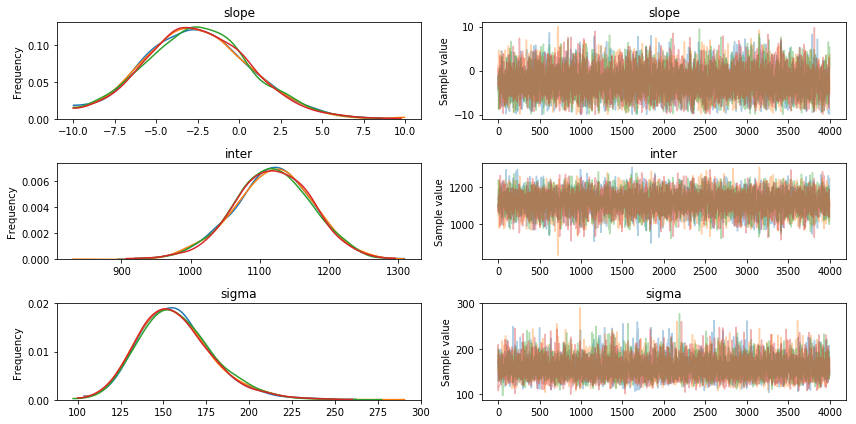

In [162]:
pm.traceplot(trace, varnames=['slope', 'inter', 'sigma'])
pass

In [168]:
with pm.Model() as model:
    slope = pm.Uniform('slope', -10, 10)
    inter = pm.Uniform('inter', 100, 10000)
    sigma = pm.Uniform('sigma', 0, 1000)

    y_est = slope* (t2 - nile.data['time'][30]) + inter
    y = pm.Normal('y', mu=y_est, sd=sigma, observed=second)
    trace = pm.sample(4000, tune=25000)

Sampling 4 chains: 100%|██████████| 116000/116000 [00:35<00:00, 3305.06draws/s]


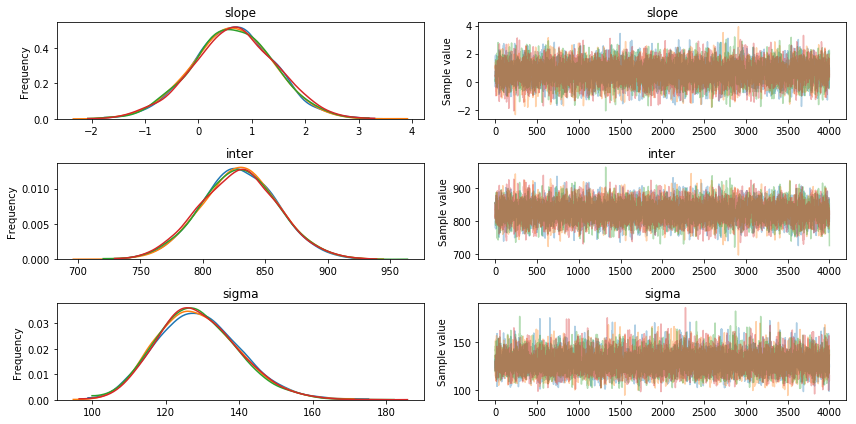

In [169]:
pm.traceplot(trace, varnames=['slope', 'inter', 'sigma'])
pass

There is a clear difference in the trends before and after the changepoint. Before the slope is negative (~-3) with an intercept around 1200 and a higher sigma. After this changepoint the slope becomes positive but smaller, less than one, and the intercept becomes smaller as well. 

## Crime Data Changepoint Problem

This is from the notes on change-point in class. Observing if and when a change happened in the time between homocides and shootings with a firearm.

In [183]:
!wget https://raw.githubusercontent.com/baltimore-sun-data/2018-shootings-analysis/master/BPD_Part_1_Victim_Based_Crime_Data.csv;

--2018-12-03 18:55:16--  https://raw.githubusercontent.com/baltimore-sun-data/2018-shootings-analysis/master/BPD_Part_1_Victim_Based_Crime_Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45658084 (44M) [text/plain]
Saving to: ‘BPD_Part_1_Victim_Based_Crime_Data.csv.4’

BPD_Part_1_Victim_B 100%[===================>]  43.54M  16.4MB/s    in 2.6s    

2018-12-03 18:55:18 (16.4 MB/s) - ‘BPD_Part_1_Victim_Based_Crime_Data.csv.4’ saved [45658084/45658084]



In [184]:
df = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv', parse_dates=[0])
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,crimeCaseNumber,Total Incidents
0,2018-07-07,23:53:00,1F,1600 PENTWOOD RD,HOMICIDE,NaN,FIREARM,413.0,NORTHEASTERN,Stonewood-Pentwood-Winsto,-76.58727,39.34782,"(39.34782, -76.58727)",Alley,NaN,1.0
1,2018-07-07,23:50:00,4E,ST & DIVISION ST,COMMON ASSAULT,O,NaN,131.0,CENTRAL,Druid Heights,-76.63936,39.30903,"(39.30903, -76.63936)",STREET,NaN,1.0
2,2018-07-07,23:18:00,4C,2500 PERRING MANOR RD,AGG. ASSAULT,I,OTHER,423.0,NORTHEASTERN,Hamilton Hills,-76.56094,39.37189,"(39.37189, -76.56094)",ROW/TOWNHO,NaN,1.0
3,2018-07-07,22:41:00,9S,3700 S HANOVER ST,SHOOTING,NaN,FIREARM,913.0,SOUTHERN,Brooklyn,-76.61033,39.23703,"(39.23703, -76.61033)",Common Bus,NaN,1.0
4,2018-07-07,22:55:00,4E,LOMBARD ST & LIGHT ST,COMMON ASSAULT,I,NaN,111.0,CENTRAL,Inner Harbor,-76.61362,39.28775,"(39.28775, -76.61362)",CONVENIENC,NaN,1.0


In [185]:
shootings = df[df.Description.isin(['HOMICIDE', 'SHOOTING']) & (df.Weapon == 'FIREARM')]

In [186]:
grouped = shootings.groupby('CrimeDate')

In [187]:
counts = grouped['Total Incidents'].sum()
counts.head()

CrimeDate
2012-01-01    1.0
2012-01-03    2.0
2012-01-05    1.0
2012-01-06    2.0
2012-01-07    3.0
Name: Total Incidents, dtype: float64

In [188]:
index = pd.date_range(counts.index[0], counts.index[-1])
counts = counts.reindex(index, fill_value=0)
counts.head()

2012-01-01    1.0
2012-01-02    0.0
2012-01-03    2.0
2012-01-04    0.0
2012-01-05    1.0
Freq: D, Name: Total Incidents, dtype: float64

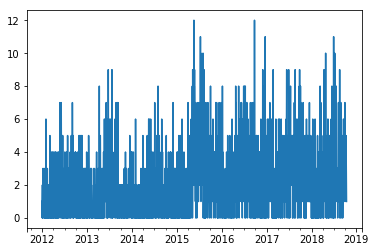

In [189]:
counts.plot()

In [199]:
niter = 20000
t = range(len(counts))
with pm.Model() as change_point:
    cp = pm.DiscreteUniform('change_point', lower=0, upper=len(counts), testval=len(counts)//2)
    mu0 = pm.Exponential('lam0', 1/counts.mean())
    mu1 = pm.Exponential('lam1', 1/counts.mean())
    mu = T.switch(t < cp, mu0, mu1)
    Y_obs = pm.Poisson('Y_obs', mu=mu, observed=counts)
    trace = pm.sample(niter)

Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3179.18draws/s]


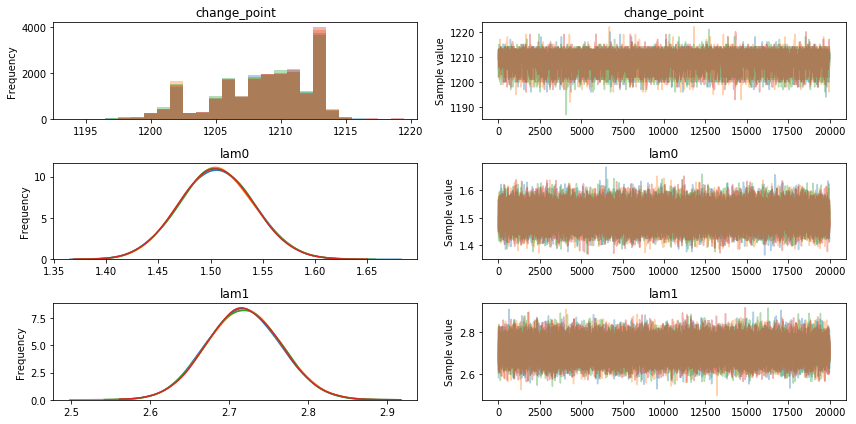

In [201]:
pm.traceplot(trace, varnames=['change_point', 'lam0', 'lam1'])
pass


There seems to have been a change in the time between firearm homicides or shootings after the changepoint. The changpoint occurs between day 1200 and 1215, afterwards the time between firearm crimes seems to go up to about 2.7 from about 1.5. 